Acceleromter Stuff
====
Initial exploration

### Prerequisites
The right version of python and various packages and probably a GPU

### where the data is
I've copied a single accelerometer file into the `data/` directory to do this initial exploration.

This isn't a viable long-term solution, but downloading from RDSF takes forever

I've also mounted the RDSF files on my `Z:` drive - change this in `userconf.yaml` if you've done something different

One can also mount the files in the right place with
```
sudo mount -t cifs -o username=mh19137,workgroup=UOB //rdsfcifs.acrc.bris.ac.uk/SEACOCH20 /mnt/z/
```

### Choose a participant

Find the relevant meal times and accelerometry data for this person

In [1]:
device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

In [2]:
# Find the accelerometer file
import pathlib

filename = f"{device_id}_{recording_id}-{participant_id}.cwa"
filepath = pathlib.Path(rf"data/{filename}")

# TODO add some code to look for the right files in all the "Week X" folders

assert filepath.exists()

In [3]:
""" Find the smartwatch data from the combined smartwatch file """
from ema import read, parse

meal_df = read.meal_info(participant_id)
allowed_meal_types = {"Snack", "Drink", "Meal", "No food/drink"}
meal_df = parse.extract_meals(meal_df, allowed_meal_types, verbose=True)

Discarding: {'Catch-up end': 1, 'Catch-up start': 1, 'No catch-up': 2, 'No response': 72}
Kept: {'Drink': 35, 'Meal': 37, 'No food/drink': 4, 'Snack': 2}


In [4]:
""" Read the accelerometry file """
samples = read.accel_info(str(filepath))

In [5]:
from pandas import Timedelta, to_datetime

# Find meal times
meal_times = meal_df["date"].map(str) + meal_df["timestamp"]

# Find an hour slot before each meal
ends = to_datetime(meal_times, format=r"%d%b%Y%H:%M:%S")
starts = ends - Timedelta(1, "hour")

### Explore some of the time series data
We'll choose one of the meals and look at the acceleration data for the preceeding hour.

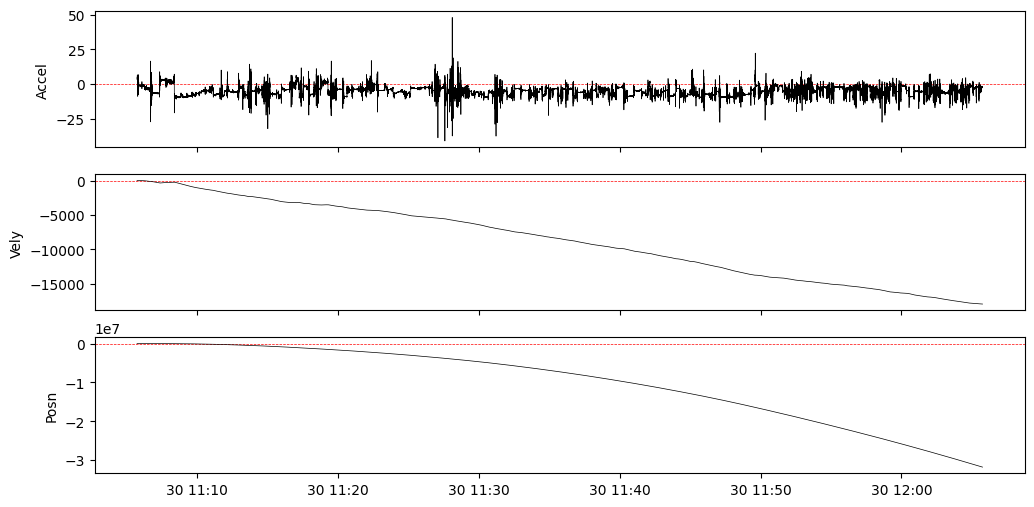

In [6]:
# Slice the series to only include accelerations in an hour preceeding a meal
import numpy as np
import matplotlib.pyplot as plt

from ema import plotting, analysis, util

meal_no = 10  # This one seems reasonable (some are before the start of the accelerometer recording)
start, end = starts.iloc[meal_no], ends.iloc[meal_no]

# Get the acceleration in one dimension
accel = samples.loc[start:end]["accel_x"]
vely = analysis.integrate(accel, dx=1 / util.SAMPLE_RATE_HZ)
posn = analysis.integrate(vely, dx=1 / util.SAMPLE_RATE_HZ)

plotting.plot_integrals(accel.index, [accel, vely, posn])

### There's a big drift in the integrated velocity and positions!

This is because the accelerometer often doesn't tare around 0 - it stabilises around a value that is small but not zero. This is a problem for us, since it means when we integrate our speed and position just get larger and larger...

We can try two things to get rid of this:
 - 1: Take a moving average and subtract it from the signal
 - 2: Apply a low-pass filter

#### Moving Average
I've explored two ways to take the moving average:
 - directly
 - with a convolution

#### Low Pass Filter
One can also take the Fourier transform of the signal, remove low-frequency components and transform again to recover the original signal with the slowly-moving parts removed.


We'll try all of these below.

In [7]:
# Remove the low frequencies from the acceleration
import pandas as pd
from ema import smooth

from importlib import reload; reload(smooth)

%matplotlib qt

accel -= np.mean(accel)

def data(method: str, **kw):
    a = smooth.remove_low_freqs(accel, method=method, **kw)
    v = analysis.integrate(accel, dx=1 / util.SAMPLE_RATE_HZ)

    # We also want to smooth the velocity
    # v = smooth.remove_low_freqs(pd.Series(v), method=method, **kw)
    x = analysis.integrate(v, dx=1 / util.SAMPLE_RATE_HZ)
    return [a, v, x]


fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

width = 10
convolved = data("convolve", width=width)
moving_avg = data("moving avg", width=width)
filtered = data("filter")

plotting.plot_integrals(accel.index, convolved, fig=fig, color="r", label="Convolution")
plotting.plot_integrals(accel.index, moving_avg, fig=fig, color="b", label="Moving Avg")
plotting.plot_integrals(accel.index, filtered, fig=fig, color="g", label="Filter", linestyle="--", linewidth=2.0)

axes[0].legend()